In [24]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd

from statsmodels.tsa.stattools import coint as st_coint
from statsmodels.tsa.stattools import adfuller
import numpy as np

import statsmodels.api as sm
from scipy.optimize import basinhopping
from scipy.stats import norm

import cPickle as cp
from math import sqrt

研究pair trading交易策略：  
方向：  
1、文献法1：  
$$R_i = \beta_0 + \beta_1 r_i + \sigma dX_t$$
2、使用协整关系建立模型(VEC)  
    problem: 由于正态性不满足，Granger两部法的协整检验无效
    solution: Johanson检验是否可行？
3、使用差分后的平稳序列  
4、使用VAR模型  

In [2]:
# data reading
df = pd.read_csv("./Data/close.csv", dtype={"date": str})

In [3]:
# some consts defined here

hs_class = [
    "SRB", "SHC", "DXI", "DXJ", "DJM"
]

yz_class = [
    "DXM", "DXY", "DXP", "ZOI"
]

gjs_class = [
    "SAU", "SAG"
]

bond_class = [
    "FXT", "FTF"
]

stock_class = [
    "FIF", "FIC", "FIH"
]

price_class = [
    "open", "high", "close", "low", "settle"
]

#COINT_TYPE = ["c", "ct", "ctt", "nc"]
COINT_TYPE = ["c"]

In [4]:
def get_coint_ar(price_ar, coint_period, coint_type):
    tmp_ar = np.ones((len(price_ar), 1)) * np.nan
    
    for idx in xrange(len(price_ar)):
        if idx < coint_period:
            continue
        
        _, pvalue, _ = st_coint(
            price_ar[idx - coint_period : idx, 0], 
            price_ar[idx - coint_period : idx, 1],
            coint_type,
        )
            
        tmp_ar[idx] = pvalue
    return tmp_ar

def get_stationary_ar(price_ar, station_period, regression):
    tmp_ar = np.ones((len(price_ar), 1)) * np.nan
    
    for idx in xrange(len(price_ar)):
        if idx < station_period:
            continue
        pvalue = adfuller(
            price_ar[idx - station_period: idx], 
            regression=regression,
        )[1]
            
        tmp_ar[idx] = pvalue
    return tmp_ar

def get_regression_ar(price_ar, regression_period):
    tmp_ar = np.ones((len(price_ar), 1)) * np.nan
    
    y = df2["FTF"].values
    x = sm.add_constant(df2["FXT"].values)
    model = sm.OLS(y, x)
    result = model.fit()
    print result.summary()
    
    for idx in xrange(len(price_ar)):
        if idx < station_period:
            continue
        pvalue = adfuller(
            price_ar[idx - station_period: idx], 
            regression=regression,
        )[1]
            
        tmp_ar[idx] = pvalue
    return tmp_ar

In [5]:
def plot_coint_p_value(ticker1, ticker2, coint_period, coint_type, save_fig=False):
    df2 = df.loc[:, [ticker1, ticker2]].dropna()

    coint_ar = get_coint_ar(df.loc[:, [ticker1, ticker2]].values, coint_period, coint_type)

    fig = plt.figure(figsize=(20, 10))
    ax1 = fig.add_subplot(111)
    ax1.plot(df2[ticker1], 'r', label=ticker1)
    ax1.plot(df2[ticker2], 'b', label=ticker2)
    plt.legend(loc="upper left")
    ax2 = ax1.twinx()
    
    pic_name = "coint_{}&{}_{}_{}".format(ticker1, ticker2, coint_period, coint_type)
    ax2.plot(coint_ar, 'g', label=pic_name)
    plt.legend(loc="upper right")
    
    if save_fig:
        fig.savefig("./Pics/{}.png".format(pic_name))
    
    return fig

def plot_station_p_value(ticker_se, ticker, station_period, regression, save_fig=False):    
    stationary_ar = get_stationary_ar(ticker_se.values, station_period, regression)
    
    fig = plt.figure(figsize=(20, 10))
    ax1 = fig.add_subplot(111)
    ax1.plot(ticker_se.values, 'r', label=ticker)
    plt.legend(loc="upper left")
    ax2 = ax1.twinx()
    
    pic_name = "stationay_{}_{}_{}".format(ticker, station_period, regression)
    ax2.plot(stationary_ar, 'g', label=pic_name)
    plt.legend(loc="upper right")
    
    if save_fig:
        fig.savefig("./Pics/{}.png".format(pic_name))
    
    return fig

method 1, according to the dissertation:  
use $\Delta P$, OU process

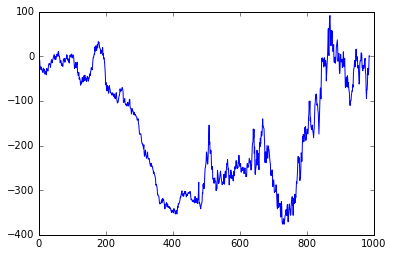

In [6]:
df2 = df.loc[:, ["SHC", "DXI"]].diff().dropna()
y = df2["SHC"].values
x = sm.add_constant(df2["DXI"].values)
model = sm.OLS(y, x)
result = model.fit()
tt = np.cumsum(result.resid)
plt.plot(tt)

从上图看出，残差项$\epsilon$可能是一个扩散过程。假设其为最简单的OU过程，即$d\epsilon'_t = -\alpha \epsilon'_t dt + dB_t$, $\epsilon'_t = \epsilon_t / \sigma$  
首先对$\sigma$进行估计  
对于其参数$\alpha$的估计，用极大似然估计。  
第一种方法是Euler近似估计  
第二种方法是路径积分方法  


In [7]:
# method 1
# first we need to estimate sigma
# according to the formula:
resid = result.resid
sigma = sqrt(sum(np.diff(resid)**2) / (len(resid) - 1))

# then we need to process the resid to make its drift a standard Brown motion
resid2 = resid / sigma

# use Euler approximation, we have
resid2_diff = np.diff(resid2)
alpha = -sum(resid2_diff * resid2[:-1]) / sum(resid2[:-1]**2)

alpha

0.99199197434849606

In [8]:
sigma

16.900802152052513

alpha为证，说明总会回归，只需要关注波动率

method 2, according to the essay:  
and we assume the $X_t$ is a white noise


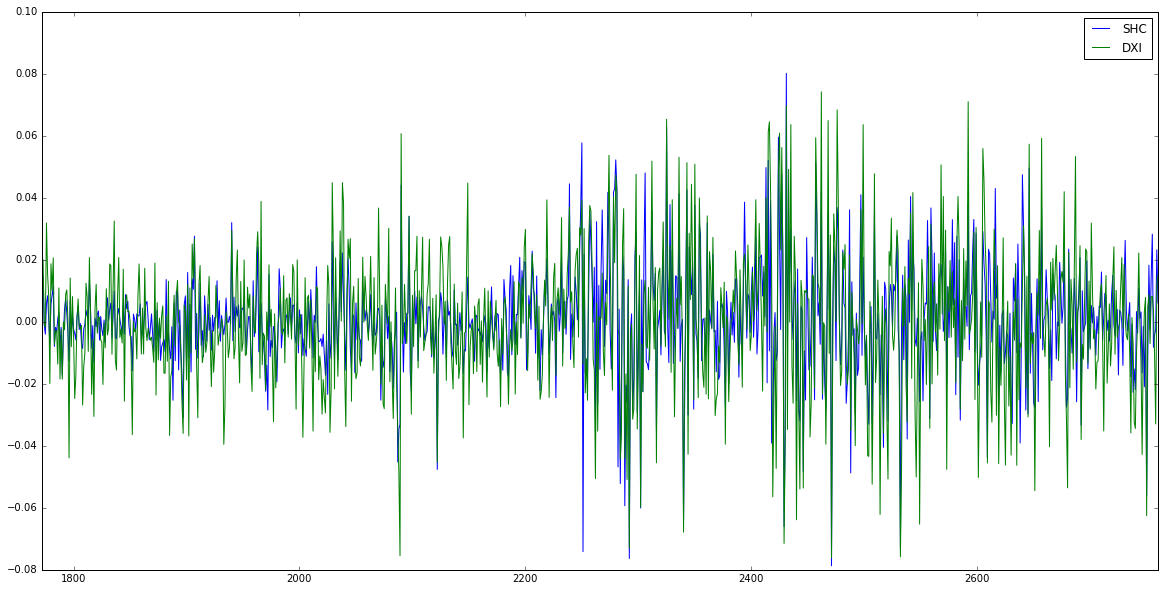

In [9]:
# get return rate data
df2 = np.log(df.loc[:, ["SHC", "DXI"]]).diff().dropna()
df2.plot(figsize=(20, 10))

In [10]:
# estimate beta0 and beta1
A = df2["SHC"].values
y = df2["DXI"].values
A = np.vstack((np.ones_like(A), A)).T

x = np.linalg.inv(A.T.dot(A)).dot(A.T).dot(y)
resid = y - A.dot(x)

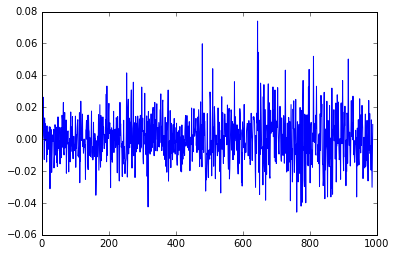

In [11]:
plt.plot(resid)

In [12]:
def back_test_last_one(args): # at this version their is no stop loss
    s_score, resid_se, buy_open_p, buy_close_p, sell_close_p, sell_open_p = args
    buy_open = s_score.quantile(buy_open_p)
    buy_close = s_score.quantile(buy_close_p)
    sell_open = s_score.quantile(sell_open_p)
    sell_close = s_score.quantile(sell_close_p)
        
    signal_ar = np.zeros((len(resid_se), 1))
    
    for i in range(1, len(resid_se)):
        if s_score[i] < sell_open and s_score[i - 1] >= sell_open: # sell open
            signal_ar[i] = -1
        elif s_score[i] < sell_close and s_score[i - 1] >= sell_close: # sell close
            signal_ar[i] = 0
        elif s_score[i] > buy_open and s_score[i - 1] <= buy_open: # buy open
            signal_ar[i] = 1
        elif s_score[i] > buy_close and s_score[i - 1] <= buy_close: # buy close
            signal_ar[i] = 0
        else: # do nothing
            signal_ar[i] = signal_ar[i - 1]
    
    return ((resid_se[2:].values * signal_ar[:-2].T).cumsum()[-1], buy_open_p, buy_close_p, sell_close_p, sell_open_p)

def back_test_sharp(args): # at this version their is no stop loss
    s_score, resid_se, buy_stop_p, buy_open_p, buy_close_p, sell_stop_p, sell_open_p, sell_close_p = args
    buy_open = s_score.quantile(buy_open_p)
    buy_close = s_score.quantile(buy_close_p)
    sell_open = s_score.quantile(sell_open_p)
    sell_close = s_score.quantile(sell_close_p)
    buy_stop = s_score.quantile(buy_stop_p)
    sell_stop = s_score.quantile(sell_stop_p)
        
    signal_ar = np.zeros((len(resid_se), 1))
    
    for i in xrange(1, len(resid_se)):
        if s_score[i] < sell_open and s_score[i - 1] >= sell_open: # sell open
            signal_ar[i] = -1
        elif s_score[i] < sell_close and s_score[i - 1] >= sell_close: # sell close
            signal_ar[i] = 0
        elif s_score[i] > buy_open and s_score[i - 1] <= buy_open: # buy open
            signal_ar[i] = 1
        elif s_score[i] > buy_close and s_score[i - 1] <= buy_close: # buy close
            signal_ar[i] = 0
        elif (s_score[i] < buy_stop and s_score[i - 1] >= buy_stop) or (s_score[i] > sell_stop and s_score[i - 1] <= sell_stop):
        	signal_ar[i] = 0
        else: # do nothing
            signal_ar[i] = signal_ar[i - 1]
    
    return_rate = (resid_se[2:].values * signal_ar[:-2].T).cumsum()
    return (return_rate[-1] / return_rate.std(), buy_stop_p, buy_open_p, buy_close_p, sell_stop_p, sell_open_p, sell_close_p)

def back_test(args): # at this version their is no stop loss
    s_score, resid_se, buy_stop_p, buy_open_p, buy_close_p, sell_stop_p, sell_open_p, sell_close_p = args
    buy_open = s_score.quantile(buy_open_p)
    buy_close = s_score.quantile(buy_close_p)
    sell_open = s_score.quantile(sell_open_p)
    sell_close = s_score.quantile(sell_close_p)
    buy_stop = s_score.quantile(buy_stop_p)
    sell_stop = s_score.quantile(sell_stop_p)
        
    signal_ar = np.zeros((len(resid_se), 1))

    
    for i in xrange(1, len(resid_se)):
        if s_score[i] < sell_open and s_score[i - 1] >= sell_open: # sell open
            signal_ar[i] = -1
        elif s_score[i] < sell_close and s_score[i - 1] >= sell_close: # sell close
            signal_ar[i] = 0
        elif s_score[i] > buy_open and s_score[i - 1] <= buy_open: # buy open
            signal_ar[i] = 1
        elif s_score[i] > buy_close and s_score[i - 1] <= buy_close: # buy close
            signal_ar[i] = 0
        elif (s_score[i] < buy_stop and s_score[i - 1] >= buy_stop) or (s_score[i] > sell_stop and s_score[i - 1] <= sell_stop):
        	signal_ar[i] = 0
        else: # do nothing
            signal_ar[i] = signal_ar[i - 1]
    
    return ((resid_se[2:].values * signal_ar[:-2].T).cumsum(), buy_stop_p, buy_open_p, buy_close_p, sell_stop_p, sell_open_p, sell_close_p)

In [54]:
resid_se = pd.Series(resid)



# there are two ways of calculating std
# way2
std2_se = resid_se.rolling(
    window=100,
).apply(lambda x: sqrt(sum(np.diff(x)**2) / (len(x) - 1)))

# calculate alpha
alpha_se = resid_se.rolling(
    window=100
).apply(lambda x: -sum(np.diff(x) * x[:-1]) / sum(x[:-1]**2))

mean_se = resid_se.rolling(
    window=100,
).mean()

Iteration:      1,   Func. Count:      7,   Neg. LLF: -2813.03017248
Iteration:      2,   Func. Count:     22,   Neg. LLF: -2813.03617401
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2813.03617353
            Iterations: 2
            Function evaluations: 33
            Gradient evaluations: 2


0      0.012720
1      0.005937
2      0.000358
3      0.002495
4      0.026318
5      0.007201
6      0.007526
7     -0.012741
8      0.013335
9      0.001873
10     0.009662
11     0.000858
12    -0.001020
13     0.000870
14    -0.014324
15     0.008357
16    -0.009566
17    -0.000421
18    -0.001220
19     0.004481
20    -0.006277
21     0.001805
22     0.007810
23     0.004267
24    -0.031065
25     0.007615
26    -0.002855
27     0.006192
28    -0.001843
29    -0.020783
         ...   
959   -0.024685
960   -0.007936
961   -0.002671
962    0.001222
963   -0.016238
964   -0.018034
965    0.002375
966    0.015767
967   -0.017060
968   -0.012505
969   -0.013322
970    0.004586
971    0.011838
972   -0.000498
973   -0.016059
974   -0.026154
975   -0.006137
976    0.024325
977    0.005022
978   -0.006940
979    0.016114
980   -0.008986
981   -0.004297
982   -0.005666
983   -0.019364
984    0.012119
985   -0.006021
986   -0.030128
987   -0.010749
988    0.009267
Name: resid, Length: 989

In [84]:
arch_model

Signature: arch_model(y, x=None, mean='Constant', lags=0, vol='Garch', p=1, o=0, q=1, power=2.0, dist='Normal', hold_back=None)
Docstring:
Convenience function to simplify initialization of ARCH models

Parameters
----------
y : {ndarray, Series, None}
    The dependent variable
x : {np.array, DataFrame}, optional
    Exogenous regressors.  Ignored if model does not permit exogenous
    regressors.
mean : str, optional
    Name of the mean model.  Currently supported options are: 'Constant',
    'Zero', 'ARX' and  'HARX'
lags : int or list (int), optional
    Either a scalar integer value indicating lag length or a list of
    integers specifying lag locations.
vol : str, optional
    Name of the volatility model.  Currently supported options are:
    'GARCH' (default),  "EGARCH', 'ARCH' and 'HARCH'
p : int, optional
    Lag order of the symmetric innovation
o : int, optional
    Lag order of the asymmetric innovation
q : int, optional
    Lag order of lagged volatility or equivalent
p

In [55]:
z_score = resid_se / std2_se

In [59]:
z_score

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
5           NaN
6           NaN
7           NaN
8           NaN
9           NaN
10          NaN
11          NaN
12          NaN
13          NaN
14          NaN
15          NaN
16          NaN
17          NaN
18          NaN
19          NaN
20          NaN
21          NaN
22          NaN
23          NaN
24          NaN
25          NaN
26          NaN
27          NaN
28          NaN
29          NaN
         ...   
959   -1.165943
960   -0.375164
961   -0.127925
962    0.056175
963   -0.778914
964   -0.866732
965    0.116536
966    0.794602
967   -0.866774
968   -0.646323
969   -0.688581
970    0.232809
971    0.605408
972   -0.028051
973   -0.827826
974   -1.345430
975   -0.316864
976    1.231771
977    0.252848
978   -0.366248
979    0.841773
980   -0.469148
981   -0.228709
982   -0.301297
983   -1.026629
984    0.635748
985   -0.318938
986   -1.578245
987   -0.562124
988    0.477504
Length: 989, dtype: floa

In [60]:
resid_se

0      0.012673
1      0.005890
2      0.000311
3      0.002449
4      0.026271
5      0.007154
6      0.007479
7     -0.012788
8      0.013288
9      0.001826
10     0.009616
11     0.000812
12    -0.001067
13     0.000824
14    -0.014371
15     0.008310
16    -0.009613
17    -0.000468
18    -0.001266
19     0.004434
20    -0.006323
21     0.001758
22     0.007764
23     0.004221
24    -0.031111
25     0.007569
26    -0.002902
27     0.006145
28    -0.001889
29    -0.020830
         ...   
959   -0.024732
960   -0.007983
961   -0.002718
962    0.001175
963   -0.016284
964   -0.018080
965    0.002329
966    0.015720
967   -0.017107
968   -0.012552
969   -0.013368
970    0.004539
971    0.011791
972   -0.000545
973   -0.016106
974   -0.026201
975   -0.006183
976    0.024279
977    0.004976
978   -0.006987
979    0.016067
980   -0.009033
981   -0.004344
982   -0.005712
983   -0.019411
984    0.012073
985   -0.006067
986   -0.030174
987   -0.010795
988    0.009220
Length: 989, dtype: floa

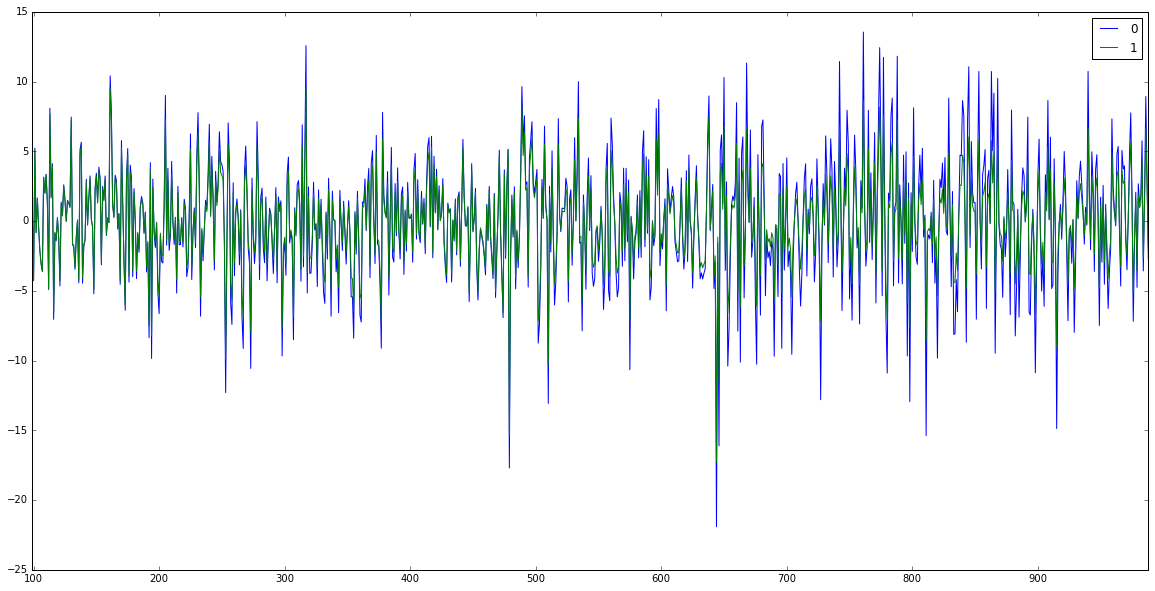

In [62]:
df = pd.DataFrame(data=[resid_se, z_score]).T.dropna()
df = df / df.iloc[0, :]
df.plot(figsize=(20, 10))

可以看到残差方差随时间变化，不是一个平稳过程，接下来先假设方差在长期内为一个固定的常数，残差平稳，进行研究

[(3.018735425975839, 0.15, 0.16, 0.42, 0.75, 0.54, 0.53), (2.9499625818732476, 0.15, 0.16, 0.37, 0.75, 0.54, 0.53), (2.9313528189687825, 0.15, 0.41, 0.42, 0.75, 0.54, 0.53), (2.9220005740461117, 0.15, 0.41, 0.42, 0.85, 0.54, 0.53), (2.9155887408878627, 0.15, 0.41, 0.47, 0.75, 0.54, 0.53), (2.907149650311494, 0.2, 0.41, 0.42, 0.75, 0.54, 0.53), (2.8997465292589446, 0.15, 0.16, 0.42, 0.85, 0.54, 0.53), (2.8862965007677737, 0.15, 0.16, 0.42, 0.8, 0.54, 0.53), (2.8847221582685867, 0.2, 0.41, 0.47, 0.75, 0.54, 0.53), (2.8755235862389452, 0.15, 0.41, 0.47, 0.85, 0.54, 0.53), (2.8670481357810571, 0.15, 0.16, 0.42, 0.85, 0.79, 0.63), (2.866365275555685, 0.2, 0.41, 0.42, 0.85, 0.54, 0.53), (2.8655007841565863, 0.15, 0.16, 0.42, 0.7, 0.54, 0.53), (2.8610511392555811, 0.15, 0.16, 0.42, 0.85, 0.79, 0.53), (2.8605792183923207, 0.15, 0.41, 0.42, 0.8, 0.54, 0.53), (2.8330632304157808, 0.15, 0.16, 0.42, 0.85, 0.84, 0.53), (2.8302399793981028, 0.15, 0.16, 0.42, 0.85, 0.84, 0.63), (2.8298786609094431, 0

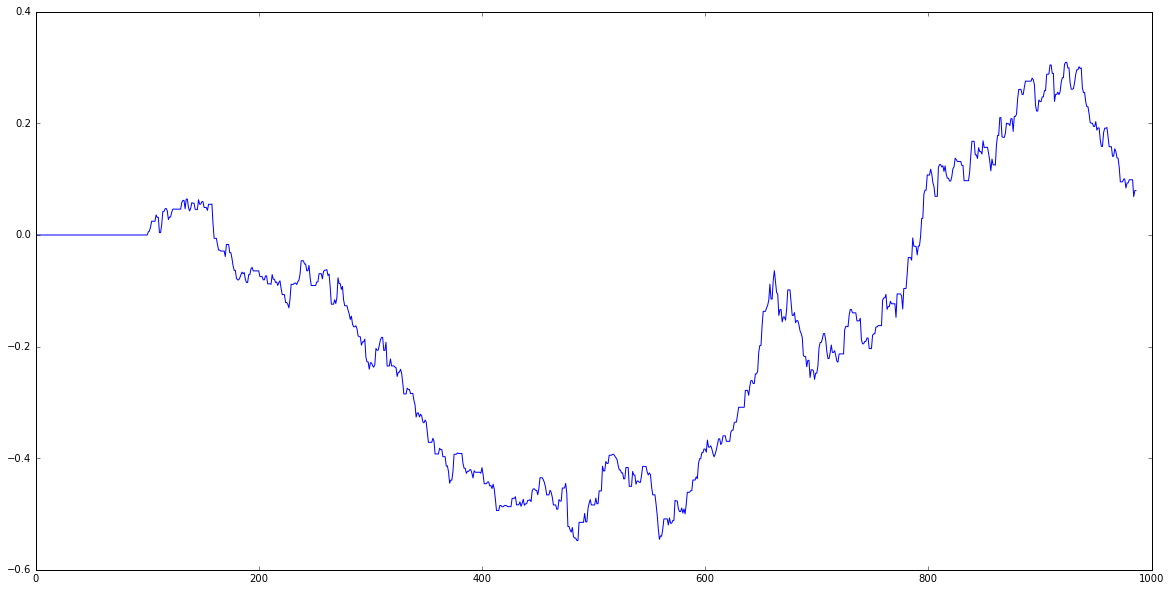

In [66]:
# the best result can achieve using std2_se, optimize return rate
with open("result_lst_SHC_DXI_sharp", "r") as fp:
    result_lst = cp.load(fp)
result_lst.sort(key=lambda x: x[0], reverse=True)
print result_lst[:100]
s_score = (resid_se - mean_se) / std2_se
res = back_test((s_score, resid_se, 0.20, 0.20, 0.25, 0.80, 0.80, 0.85))
fig = plt.figure(figsize=(20, 10))
plt.plot(res[0])

In [69]:
from scipy.stats import skew
skew(z_score.dropna())

0.3688333518753901

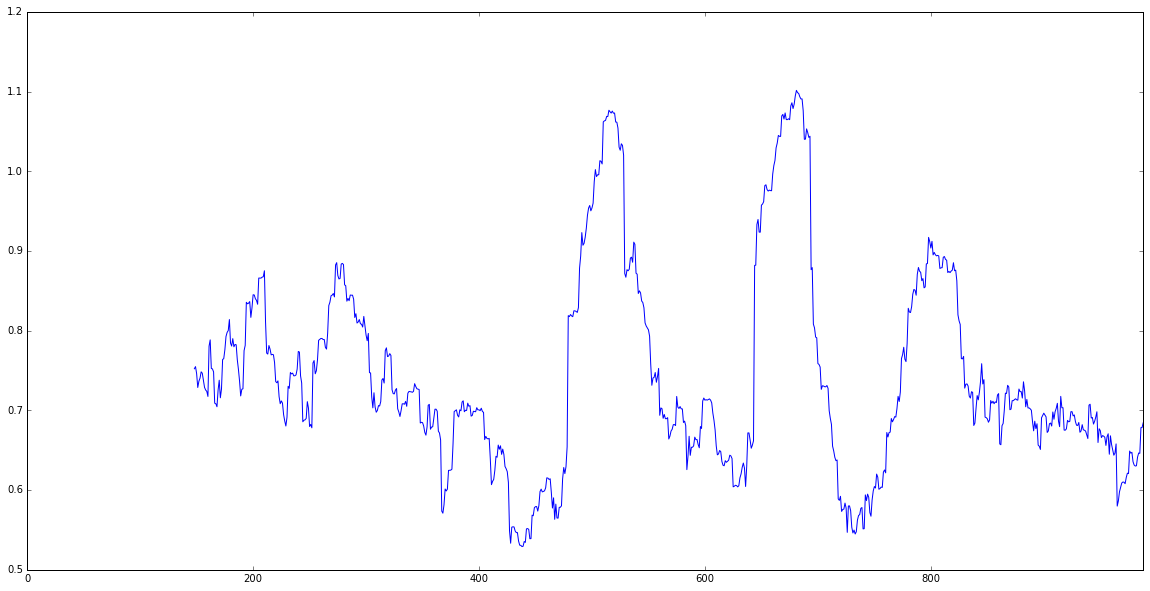

In [75]:
z_score.rolling(50).std().plot(figsize=(20, 10))

In [16]:
def test_and_print(ticker1, ticker2):
    df2 = np.log(df.loc[:, [ticker1, ticker2]]).diff().dropna()

    # estimate beta0 and beta1
    A = df2[ticker1].values
    y = df2[ticker2].values
    A = np.vstack((np.ones_like(A), A)).T

    x = np.linalg.inv(A.T.dot(A)).dot(A.T).dot(y)
    resid = y - A.dot(x)

    resid_se = pd.Series(resid)

    # there are two ways of calculating std
    # way2
    std2_se = resid_se.rolling(
        window=100,
    ).apply(lambda x: sqrt(sum(np.diff(x)**2) / (len(x) - 1)))

    # calculate alpha
    mean_se = resid_se.rolling(
        window=100,
    ).mean()
    res = back_test((s_score, resid_se, 0.15, 0.16, 0.30, 0.85, 0.84, 0.70))
    fig = plt.figure(figsize=(20, 10))
    plt.plot(res[0], label="{}_{}".format(ticker1, ticker2))
    plt.legend()

In [26]:
'''
for idx, t1 in enumerate(bond_class):
    for t2 in bond_class[idx:]:
        if t1 == t2:
            continue
        test_and_print(t1, t2)

for idx, t1 in enumerate(stock_class):
    for t2 in stock_class[idx:]:
        if t1 == t2:
            continue
        test_and_print(t1, t2)

for idx, t1 in enumerate(hs_class):
    for t2 in hs_class[idx:]:
        if t1 == t2:
            continue
        test_and_print(t1, t2)

for idx, t1 in enumerate(yz_lass):
    for t2 in yz_class[idx:]:
        if t1 == t2:
            continue
        test_and_print(t1, t2)

for idx, t1 in enumerate(gjs_class):
    for t2 in gjs_class[idx:]:
        if t1 == t2:
            continue
        test_and_print(t1, t2)
'''

'\nfor idx, t1 in enumerate(bond_class):\n    for t2 in bond_class[idx:]:\n        if t1 == t2:\n            continue\n        test_and_print(t1, t2)\n\nfor idx, t1 in enumerate(stock_class):\n    for t2 in stock_class[idx:]:\n        if t1 == t2:\n            continue\n        test_and_print(t1, t2)\n\nfor idx, t1 in enumerate(hs_class):\n    for t2 in hs_class[idx:]:\n        if t1 == t2:\n            continue\n        test_and_print(t1, t2)\n\nfor idx, t1 in enumerate(yz_lass):\n    for t2 in yz_class[idx:]:\n        if t1 == t2:\n            continue\n        test_and_print(t1, t2)\n\nfor idx, t1 in enumerate(gjs_class):\n    for t2 in gjs_class[idx:]:\n        if t1 == t2:\n            continue\n        test_and_print(t1, t2)\n'

At this block, we try to fit a GARCH model to predict volatility
for utilities, we need a data pool, a back testing function

In [18]:
def array_shift(ar, n):
    ar2 = ar.copy()
    if n == 0:
        return ar2
    ar2[n : ] = ar2[: -n]
    ar2[ : n] = 0
    return ar2

In [42]:
# first we need to construct a model GARCH(m, n, o, p, q)
r1 = df2["SHC"].values.T
r2 = df2["DXI"].values.T
a = 0
b = 0
t = 0
g = 1
r = 1

In [28]:
alpha = np.random.rand(a + 1, 1)
beta = np.random.rand(b, 1)
theta = np.random.rand(t + 1, 1)
gamma = np.random.rand(g + 1, 1)
rho = np.random.rand(r, 1)

r1_lag = np.vstack((np.ones_like(r1), reduce(lambda x, y: np.vstack((x, y)), [r1] + [array_shift(r1, i) for i in range(1, a)]))).T
r2_lag = reduce(lambda x, y: np.vstack((x, y)), [r2] + [array_shift(r2, i) for i in range(0, t)]).T

at = np.ones((len(r1), 1))
sigma_squre = np.ones((len(r1), 1))
at[0 : max(b, r)] = np.random.rand(max(b, r), 1)
sigma_squre[0 : g] = np.random.rand(g, 1)


def calc_likelihood(alpha, beta, theta, gamma, rho):
    for i in xrange(len(r1)):
        if i < r or i < b or i < g:
            continue
        sigma_squre[i] = min(np.vstack((np.array([1]), sigma_squre[i-g:i])).T.dot(gamma) + (at[i-r:i]**2).dot(rho), 1e-5)
        at[i] = r1[i] - r1_lag[i, :].dot(alpha) - at[i-b : i].dot(beta) - r2_lag[i, :].dot(theta)
    return sum(np.log(norm.pdf(at / sigma_squre)))

In [35]:
def target_func(x):
    alpha = x[0 : a + 1]
    beta = x[a + 1 : a + 1 + b]
    theta = x[a + 1 + b : a + 1 + b + t + 1]
    gamma = x[a + 1 + b + t + 1 : a + 1 + b + t + 1 + g + 1]
    rho = x[a + 1 + b + t + 1 + g + 1 : a + 1 + b + t + 1 + g + 1 + r]
    return calc_likelihood(alpha, beta, theta, gamma, rho)

In [40]:
init_x = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [41]:
basinhopping(target_func, init_x)

ValueError: shapes (1,1) and (0,) not aligned: 1 (dim 1) != 0 (dim 0)